🔹 Loading neural response matrix...
Total neurons: 39209, total samples: 5900
Detected time bins: 1

🔸 AREA: VISp
14382 neurons in VISp
Running NMF...
W shape = (118, 20), H shape = (20, 14382)
Reconstruction error: 60.3993


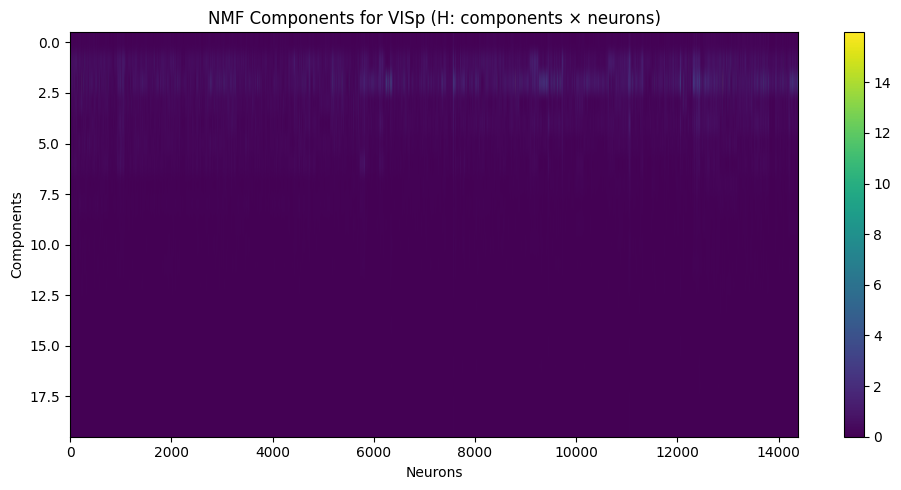


🔸 AREA: VISl
8323 neurons in VISl
Running NMF...
W shape = (118, 20), H shape = (20, 8323)
Reconstruction error: 46.1223


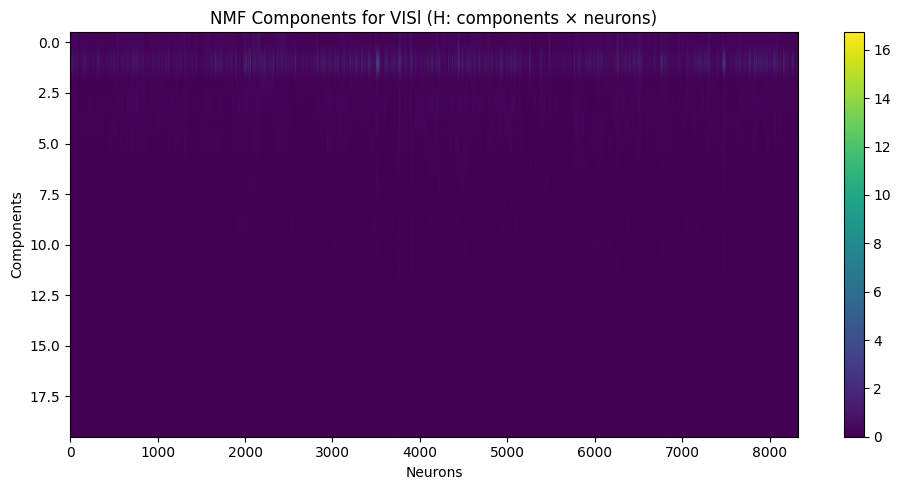


🔸 AREA: VISrl
5444 neurons in VISrl
Running NMF...
W shape = (118, 20), H shape = (20, 5444)
Reconstruction error: 19.4085


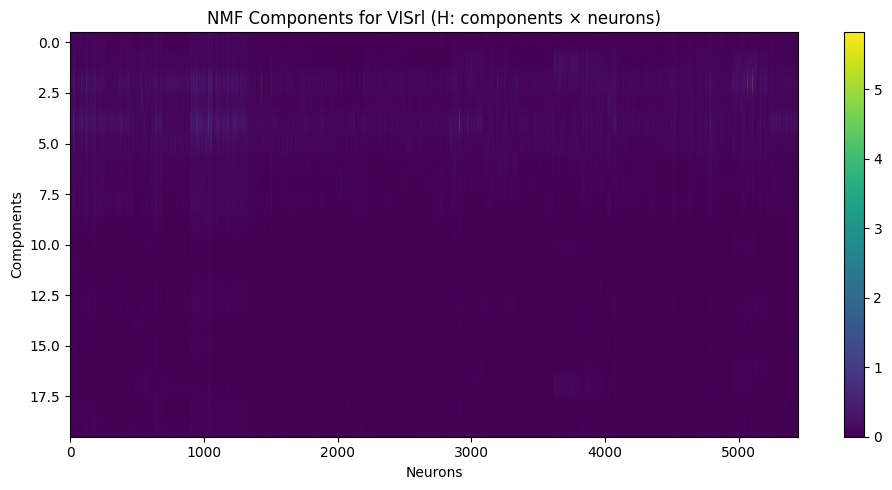


🔸 AREA: VISal
4249 neurons in VISal
Running NMF...
W shape = (118, 20), H shape = (20, 4249)
Reconstruction error: 27.4569


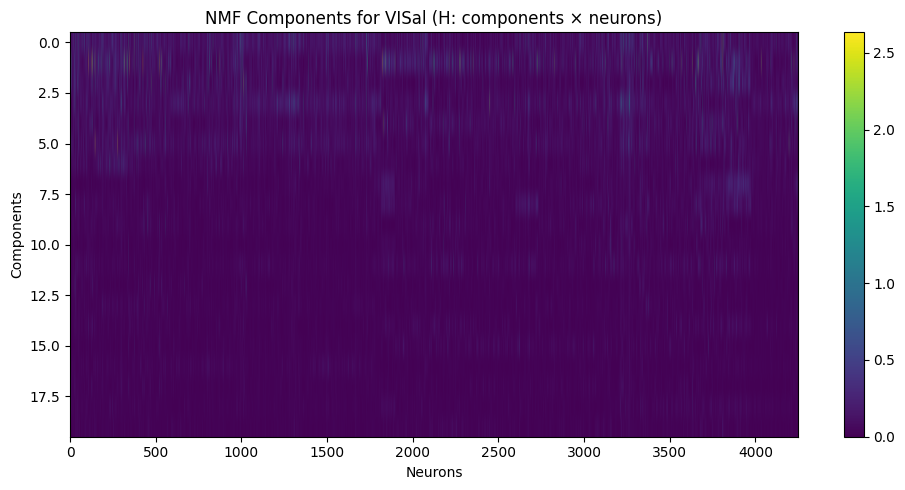


🔸 AREA: VISam
2040 neurons in VISam
Running NMF...
W shape = (118, 20), H shape = (20, 2040)
Reconstruction error: 16.6602


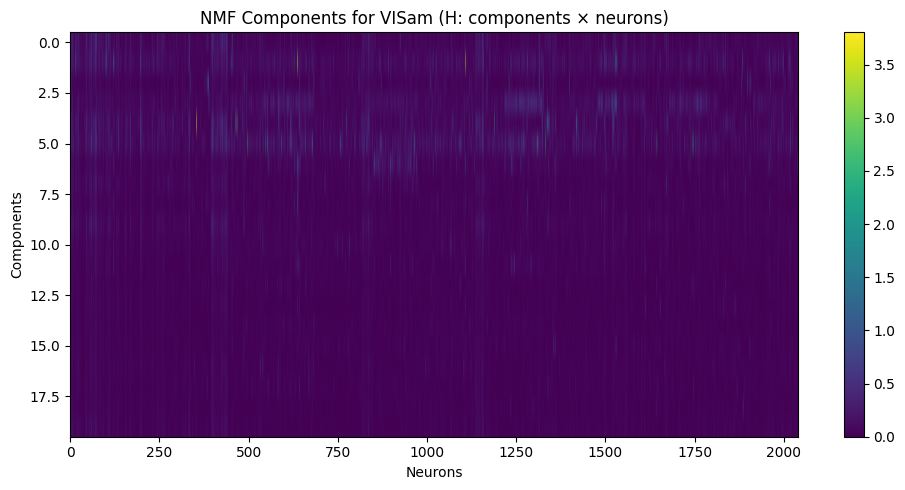


🔸 AREA: VISpm
4771 neurons in VISpm
Running NMF...
W shape = (118, 20), H shape = (20, 4771)
Reconstruction error: 26.8991


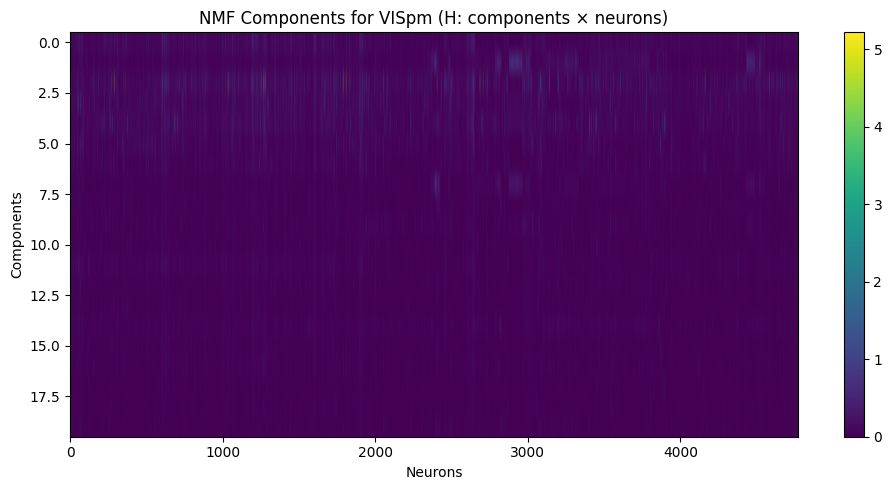


💾 Saved NMF results to nmf_results.pkl


In [4]:
#!/usr/bin/env python3
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

# ----------------------------------------------------
# CONFIG
# ----------------------------------------------------
NEURAL_PATH = '/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy'
AREAS_PATH  = '/home/maria/MITNeuralComputation/visualization/brain_area.npy'

AREAS = ["VISp", "VISl", "VISrl", "VISal", "VISam", "VISpm"]
N_IMAGES = 118
N_TRIALS = 50
N_COMPONENTS = 20
RANDOM_SEED = 0

# ----------------------------------------------------
# LOAD
# ----------------------------------------------------
print("🔹 Loading neural response matrix...")
dat_all = np.load(NEURAL_PATH, mmap_mode='r')  # (n_neurons_total × (images*trials*time))
areas = np.load(AREAS_PATH, allow_pickle=True)

n_neurons_total, n_total = dat_all.shape
print(f"Total neurons: {n_neurons_total}, total samples: {n_total}")

# Infer #time bins exactly like before
n_time = n_total // (N_IMAGES * N_TRIALS)
if N_IMAGES * N_TRIALS * n_time != n_total:
    raise ValueError("Inconsistent shape: cannot infer time dimension.")
print(f"Detected time bins: {n_time}")


# ----------------------------------------------------
# NMF per area
# ----------------------------------------------------
results = {}

for area in AREAS:
    print("\n========================================")
    print(f"🔸 AREA: {area}")
    print("========================================")

    # ------------------------------------------------
    # Extract neurons for this area
    # ------------------------------------------------
    area_mask = (areas == area)
    dat = dat_all[area_mask]   # shape (n_neurons_area × n_total)
    n_neurons_area = dat.shape[0]
    print(f"{n_neurons_area} neurons in {area}")

    # ------------------------------------------------
    # Reshape to: neurons × images × trials × time
    # ------------------------------------------------
    dat = dat.reshape(n_neurons_area,
                      N_IMAGES,
                      N_TRIALS,
                      n_time)

    # ------------------------------------------------
    # Average over trials & time → stimulus-locked
    # ------------------------------------------------
    # Result: (neurons × images)
    dat_avg = dat.mean(axis=(2,3))

    # Transpose to (images × neurons) for NMF
    X = dat_avg.T  # (images × neurons)

    # Ensure non-negative (NMF requirement)
    X = np.maximum(X, 0)

    # ------------------------------------------------
    # Run NMF
    # ------------------------------------------------
    print("Running NMF...")
    model = NMF(
        n_components=N_COMPONENTS,
        init='nndsvda',
        random_state=RANDOM_SEED,
        max_iter=5000
    )

    W = model.fit_transform(X)   # (images × components)
    H = model.components_        # (components × neurons)

    print(f"W shape = {W.shape}, H shape = {H.shape}")
    print(f"Reconstruction error: {model.reconstruction_err_:.4f}")

    results[area] = (W, H)

    # ------------------------------------------------
    # Plot components (H)
    # ------------------------------------------------
    plt.figure(figsize=(10,5))
    plt.imshow(H, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.title(f"NMF Components for {area} (H: components × neurons)")
    plt.xlabel("Neurons")
    plt.ylabel("Components")
    plt.tight_layout()
    plt.show()


# ----------------------------------------------------
# SAVE
# ----------------------------------------------------
with open("nmf_results.pkl", "wb") as f:
    pickle.dump(results, f)

print("\n💾 Saved NMF results to nmf_results.pkl")


🔹 Loading neural response matrix...
Total neurons: 39209, total samples: 5900
Detected time bins: 1
🔹 Loading ViT embeddings...
🔹 PCA on ViT CLR embeddings...
✅ ViT PCs covering 90% variance: 44

🔸 AREA: VISp
Running NMF...
W shape = (118, 20), H shape = (20, 14382)
Reconstruction error: 60.3993
Cross-covariance matrix shape: (44, 20)


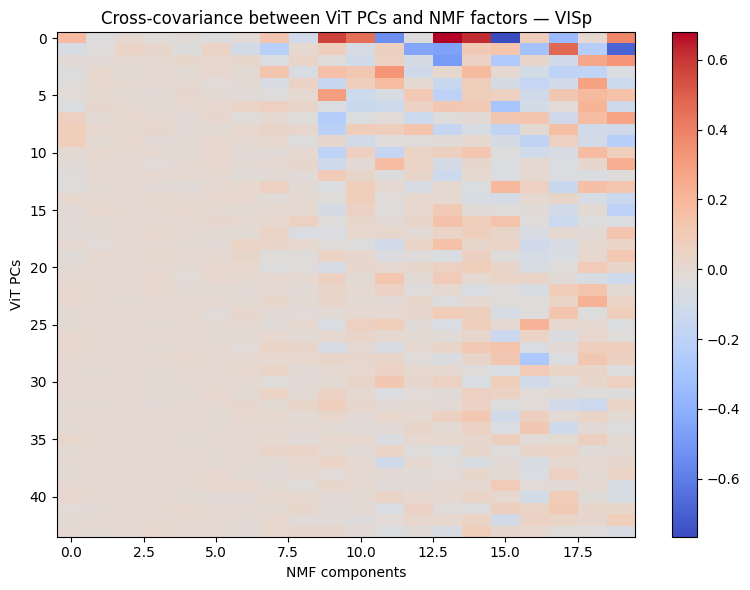


🔸 AREA: VISl
Running NMF...
W shape = (118, 20), H shape = (20, 8323)
Reconstruction error: 46.1515
Cross-covariance matrix shape: (44, 20)


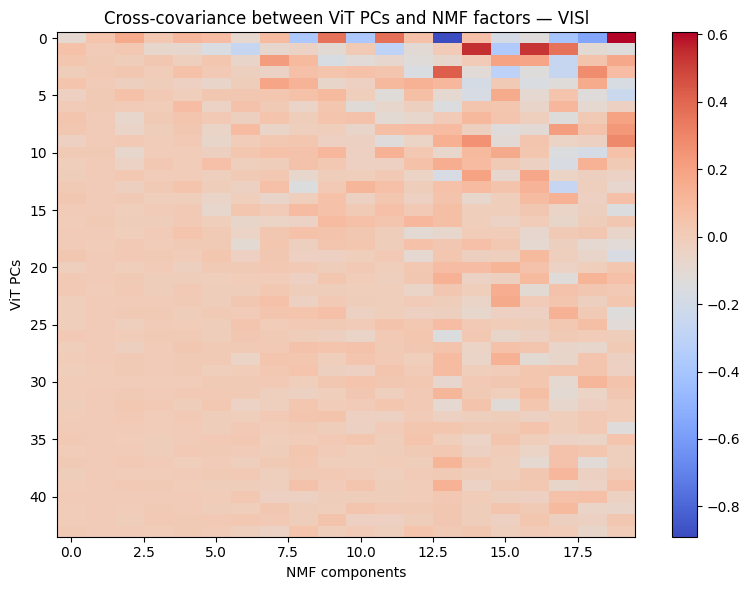


🔸 AREA: VISrl
Running NMF...
W shape = (118, 20), H shape = (20, 5444)
Reconstruction error: 19.4035
Cross-covariance matrix shape: (44, 20)


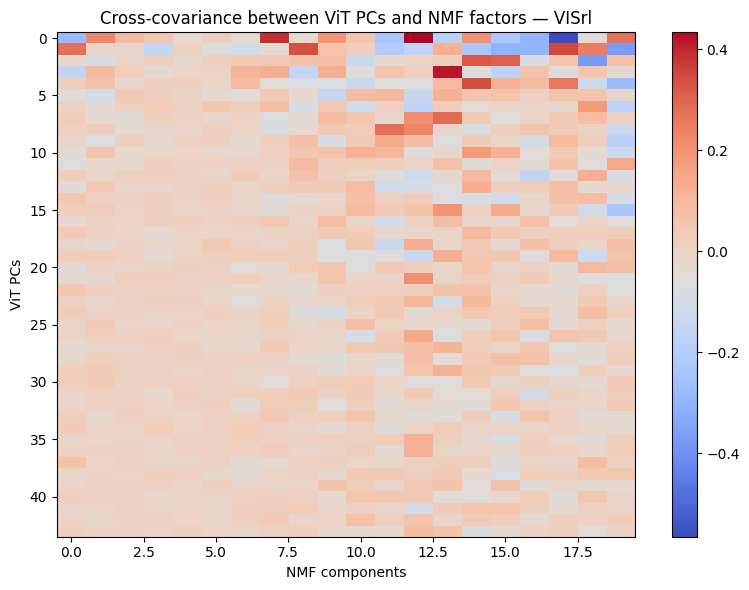


🔸 AREA: VISal
Running NMF...
W shape = (118, 20), H shape = (20, 4249)
Reconstruction error: 27.4708
Cross-covariance matrix shape: (44, 20)


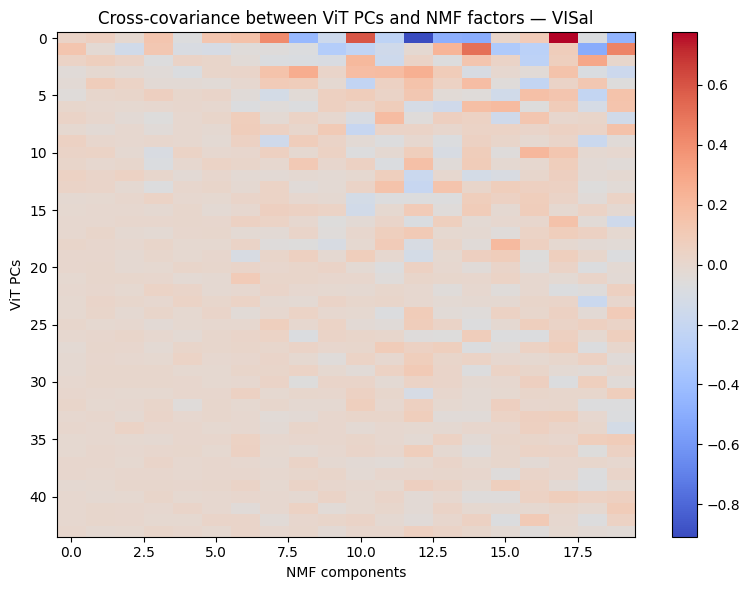


🔸 AREA: VISam
Running NMF...
W shape = (118, 20), H shape = (20, 2040)
Reconstruction error: 16.6255
Cross-covariance matrix shape: (44, 20)


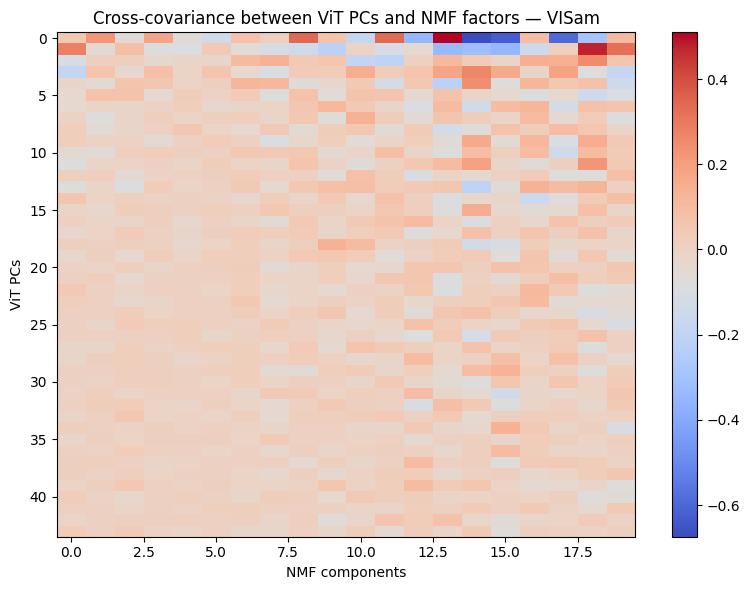


🔸 AREA: VISpm
Running NMF...
W shape = (118, 20), H shape = (20, 4771)
Reconstruction error: 26.8858
Cross-covariance matrix shape: (44, 20)


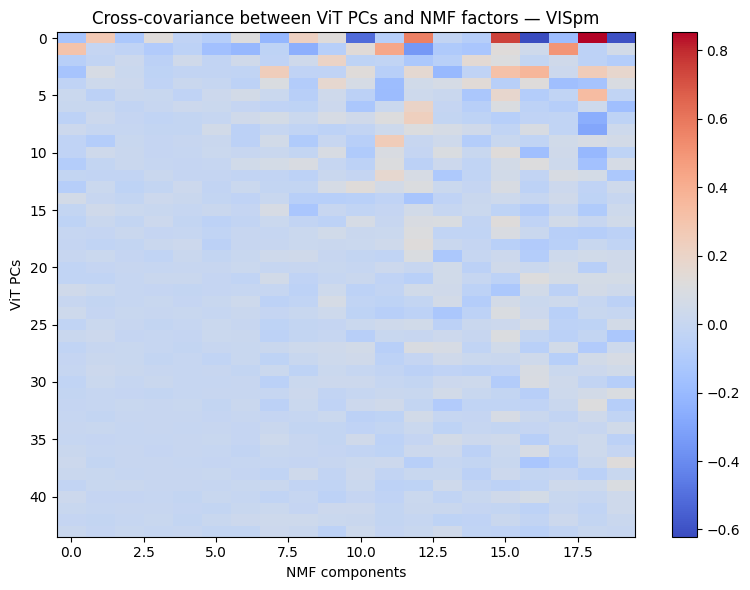


💾 Saved cross-covariance matrices → cross_covariance_viT_nmf.pkl


In [5]:
#!/usr/bin/env python3
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF
from scipy.special import softmax
from skbio.stats.composition import clr

# ----------------------------------------------------
# CONFIG
# ----------------------------------------------------
NEURAL_PATH = '/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy'
AREAS_PATH  = '/home/maria/MITNeuralComputation/visualization/brain_area.npy'

VIT_PATH    = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'

AREAS = ["VISp", "VISl", "VISrl", "VISal", "VISam", "VISpm"]

N_IMAGES = 118
N_TRIALS = 50
N_COMPONENTS = 20     # NMF components
VAR_CUTOFF  = 0.90
RANDOM_SEED = 42

# ----------------------------------------------------
# LOAD NEURAL DATA
# ----------------------------------------------------
print("🔹 Loading neural response matrix...")
dat_all = np.load(NEURAL_PATH, mmap_mode='r')   # (n_neurons_total × (images*trials*time))
areas = np.load(AREAS_PATH, allow_pickle=True)

n_neurons_total, n_total = dat_all.shape
print(f"Total neurons: {n_neurons_total}, total samples: {n_total}")

# Infer #time bins
n_time = n_total // (N_IMAGES * N_TRIALS)
if N_IMAGES * N_TRIALS * n_time != n_total:
    raise ValueError("Inconsistent shape: cannot infer time dimension.")

print(f"Detected time bins: {n_time}")


# ----------------------------------------------------
# LOAD & PCA THE VIT EMBEDDINGS
# ----------------------------------------------------
print("🔹 Loading ViT embeddings...")

with open(VIT_PATH, 'rb') as f:
    vit_logits = pickle.load(f)['natural_scenes']  # (N_IMAGES × D_vit)

Xv = np.asarray(vit_logits)
Xv = softmax(Xv, axis=1)
Xv = clr(Xv + 1e-12)

print("🔹 PCA on ViT CLR embeddings...")
vit_pca_full = PCA(random_state=RANDOM_SEED).fit(Xv)
vit_cumvar = np.cumsum(vit_pca_full.explained_variance_ratio_)
vit_ncomp = np.searchsorted(vit_cumvar, VAR_CUTOFF) + 1

vit_pca = PCA(n_components=vit_ncomp, random_state=RANDOM_SEED)
Zv = vit_pca.fit_transform(Xv)      # (images × vit_ncomp)

print(f"✅ ViT PCs covering {VAR_CUTOFF*100:.0f}% variance: {vit_ncomp}")


# ----------------------------------------------------
# NMF PER AREA AND CROSS-COVARIANCE
# ----------------------------------------------------
cross_cov_results = {}

for area in AREAS:
    print("\n========================================")
    print(f"🔸 AREA: {area}")
    print("========================================")

    area_mask = (areas == area)
    dat = dat_all[area_mask]    # (n_neurons_area × n_total)
    n_neurons_area = dat.shape[0]

    # Reshape: neurons × images × trials × time
    dat = dat.reshape(
        n_neurons_area,
        N_IMAGES,
        N_TRIALS,
        n_time
    )

    # Average over trials and time
    dat_avg = dat.mean(axis=(2,3))   # (neurons × images)

    # NMF expects (samples × features) = (images × neurons)
    X = dat_avg.T
    X = np.maximum(X, 0)

    # -----------------------------
    # NMF decomposition
    # -----------------------------
    print("Running NMF...")
    nmf_model = NMF(
        n_components=N_COMPONENTS,
        init='nndsvda',
        max_iter=5000,
        random_state=RANDOM_SEED
    )

    W = nmf_model.fit_transform(X)   # (images × components)
    H = nmf_model.components_        # (components × neurons)

    print(f"W shape = {W.shape}, H shape = {H.shape}")
    print(f"Reconstruction error: {nmf_model.reconstruction_err_:.4f}")

    # -----------------------------
    # CROSS-COVARIANCE WITH ViT PCs
    # -----------------------------
    # Zv: (images × vit_ncomp)
    # W:  (images × nmf_components)

    # Center both
    Zv0 = Zv - Zv.mean(axis=0, keepdims=True)
    W0  = W  - W.mean(axis=0, keepdims=True)

    C = (Zv0.T @ W0) / (N_IMAGES - 1)  # (vit_ncomp × nmf_components)

    print(f"Cross-covariance matrix shape: {C.shape}")

    cross_cov_results[area] = C

    # -----------------------------
    # VISUALIZATION
    # -----------------------------
    plt.figure(figsize=(8, 6))
    plt.imshow(C, aspect='auto', cmap='coolwarm')
    plt.colorbar()
    plt.title(f"Cross-covariance between ViT PCs and NMF factors — {area}")
    plt.xlabel("NMF components")
    plt.ylabel("ViT PCs")
    plt.tight_layout()
    plt.show()


# -----------------------------
# SAVE RESULTS
# -----------------------------
with open("cross_covariance_viT_nmf.pkl", "wb") as f:
    pickle.dump(cross_cov_results, f)

print("\n💾 Saved cross-covariance matrices → cross_covariance_viT_nmf.pkl")


🔹 Loading neural response matrix...
Total neurons = 39209, time bins = 1

🔹 Loading ViT embeddings...
🔹 PCA on ViT CLR embeddings...
✅ ViT PCs covering 90% variance: 44

🔸 AREA: VISp
Using 14382 neurons
Running NMF...
W shape = (118, 20), H shape = (20, 14382)
NMF reconstruction error: 60.3993
Correlation matrix shape for VISp: (44, 20)


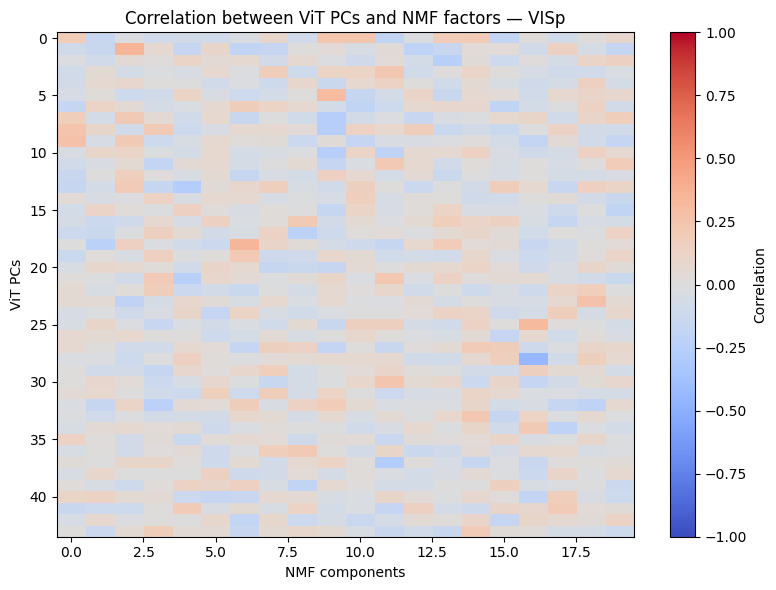


🔸 AREA: VISl
Using 8323 neurons
Running NMF...
W shape = (118, 20), H shape = (20, 8323)
NMF reconstruction error: 46.1515
Correlation matrix shape for VISl: (44, 20)


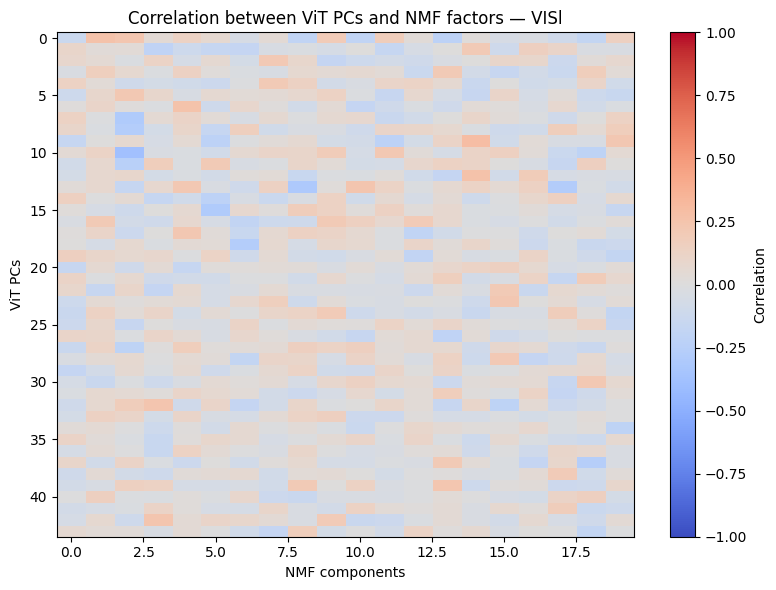


🔸 AREA: VISrl
Using 5444 neurons
Running NMF...
W shape = (118, 20), H shape = (20, 5444)
NMF reconstruction error: 19.4035
Correlation matrix shape for VISrl: (44, 20)


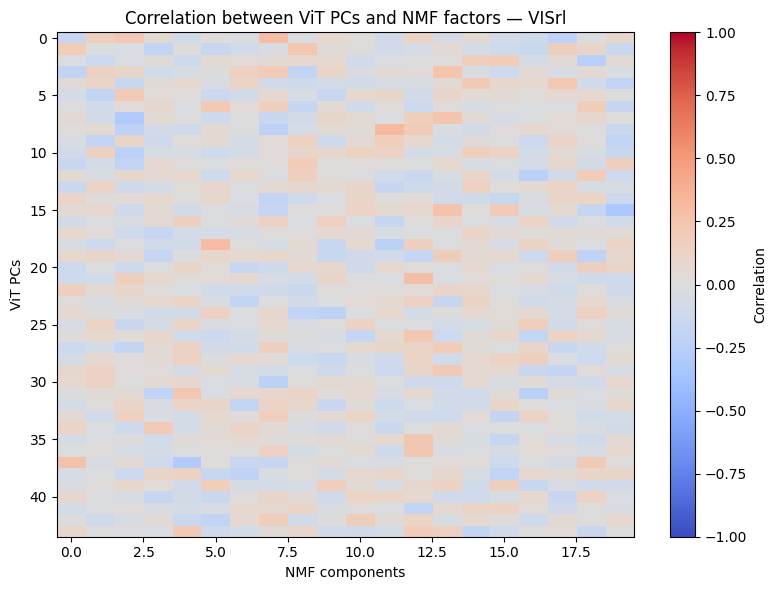


🔸 AREA: VISal
Using 4249 neurons
Running NMF...
W shape = (118, 20), H shape = (20, 4249)
NMF reconstruction error: 27.4708
Correlation matrix shape for VISal: (44, 20)


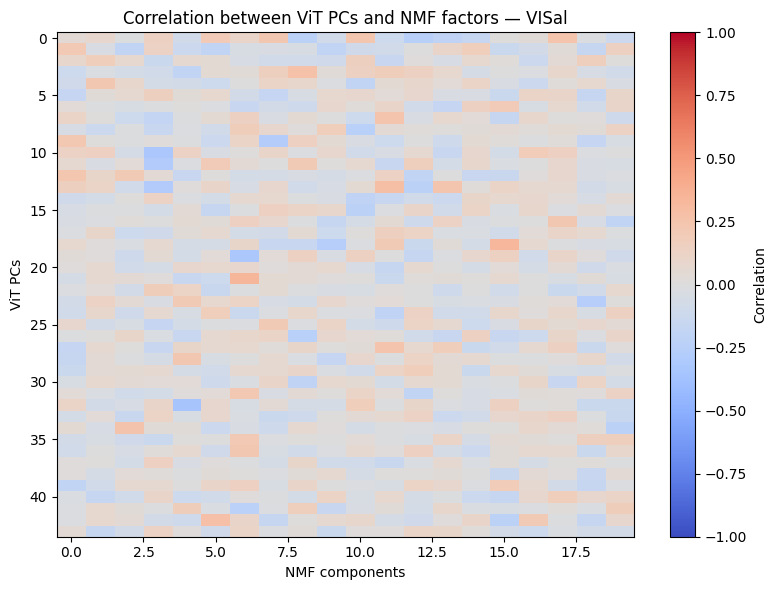


🔸 AREA: VISam
Using 2040 neurons
Running NMF...
W shape = (118, 20), H shape = (20, 2040)
NMF reconstruction error: 16.6255
Correlation matrix shape for VISam: (44, 20)


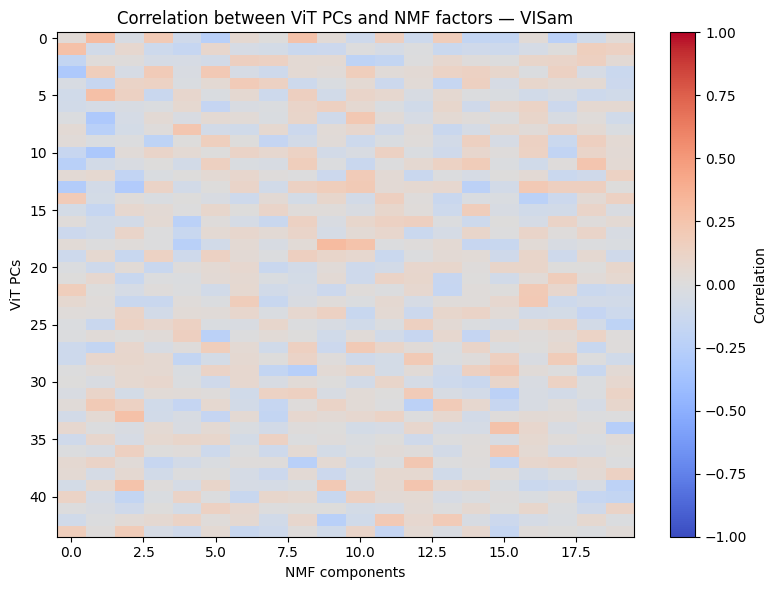


🔸 AREA: VISpm
Using 4771 neurons
Running NMF...
W shape = (118, 20), H shape = (20, 4771)
NMF reconstruction error: 26.8858
Correlation matrix shape for VISpm: (44, 20)


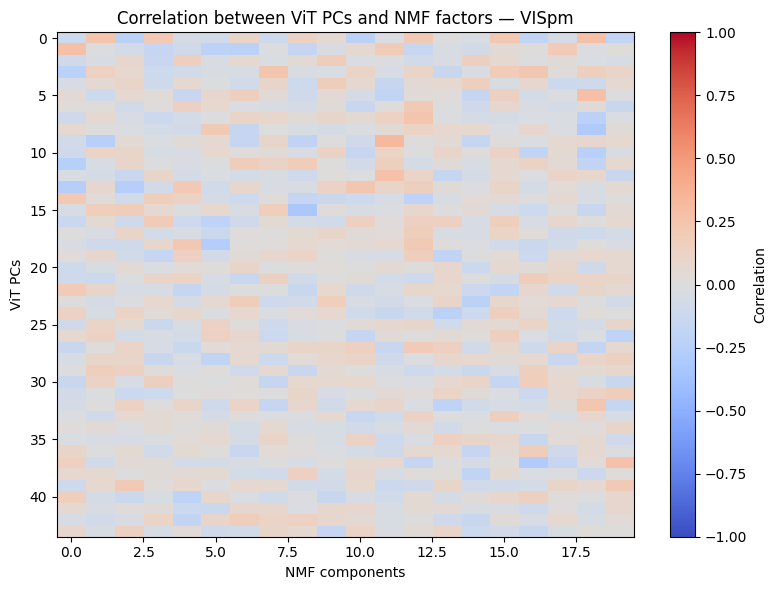


💾 Saved correlation matrices → correlation_viT_nmf.pkl


In [7]:
#!/usr/bin/env python3
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF
from scipy.special import softmax
from skbio.stats.composition import clr

# ----------------------------------------------------
# CONFIG
# ----------------------------------------------------
NEURAL_PATH = '/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy'
AREAS_PATH  = '/home/maria/MITNeuralComputation/visualization/brain_area.npy'
VIT_PATH    = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'

AREAS = ["VISp", "VISl", "VISrl", "VISal", "VISam", "VISpm"]

N_IMAGES    = 118
N_TRIALS    = 50
N_COMPONENTS = 20     # NMF components
VAR_CUTOFF   = 0.90   # ViT PCA variance threshold
RANDOM_SEED  = 42

# ----------------------------------------------------
# LOAD NEURAL DATA
# ----------------------------------------------------
print("🔹 Loading neural response matrix...")
dat_all = np.load(NEURAL_PATH, mmap_mode='r')   # shape: (n_neurons_total × (images*trials*time))
areas = np.load(AREAS_PATH, allow_pickle=True)

n_neurons_total, n_total = dat_all.shape

# Infer time bins
n_time = n_total // (N_IMAGES * N_TRIALS)
if N_IMAGES * N_TRIALS * n_time != n_total:
    raise ValueError("Cannot infer time dimension.")

print(f"Total neurons = {n_neurons_total}, time bins = {n_time}")


# ----------------------------------------------------
# LOAD & PCA THE ViT EMBEDDINGS
# ----------------------------------------------------
print("\n🔹 Loading ViT embeddings...")
with open(VIT_PATH, 'rb') as f:
    vit_logits = pickle.load(f)['natural_scenes']  # (images × D_vit)

Xv = np.asarray(vit_logits)
Xv = softmax(Xv, axis=1)
Xv = clr(Xv + 1e-12)

print("🔹 PCA on ViT CLR embeddings...")
vit_pca_full = PCA(random_state=RANDOM_SEED).fit(Xv)
vit_cumvar   = np.cumsum(vit_pca_full.explained_variance_ratio_)
vit_ncomp    = np.searchsorted(vit_cumvar, VAR_CUTOFF) + 1

vit_pca = PCA(n_components=vit_ncomp, random_state=RANDOM_SEED)
Zv = vit_pca.fit_transform(Xv)     # (images × vit_ncomp)

print(f"✅ ViT PCs covering {VAR_CUTOFF*100:.0f}% variance: {vit_ncomp}")


# ----------------------------------------------------
# MAIN LOOP: NMF + CORRELATION per area
# ----------------------------------------------------
correlation_results = {}

for area in AREAS:
    print("\n========================================")
    print(f"🔸 AREA: {area}")
    print("========================================")

    # ------------------------------------------------
    # Select neurons in this area
    # ------------------------------------------------
    area_mask = (areas == area)
    dat = dat_all[area_mask]     # (n_neurons_area × n_total)
    n_neurons_area = dat.shape[0]

    print(f"Using {n_neurons_area} neurons")

    # ------------------------------------------------
    # Reshape -> (neurons × images × trials × time)
    # ------------------------------------------------
    dat = dat.reshape(
        n_neurons_area,
        N_IMAGES,
        N_TRIALS,
        n_time
    )

    # ------------------------------------------------
    # Average over trials + time → stimulus-locked
    # ------------------------------------------------
    dat_avg = dat.mean(axis=(2, 3))    # (neurons × images)

    # ------------------------------------------------
    # NMF expects (samples × features) = (images × neurons)
    # ------------------------------------------------
    X = dat_avg.T                      # (images × neurons)
    X = np.maximum(X, 0)               # ensure non-negative

    # ------------------------------------------------
    # NMF
    # ------------------------------------------------
    print("Running NMF...")

    nmf_model = NMF(
        n_components=N_COMPONENTS,
        init='nndsvda',
        max_iter=5000,
        random_state=RANDOM_SEED
    )

    W = nmf_model.fit_transform(X)   # (images × nmf_components)
    H = nmf_model.components_        # (nmf_components × neurons)

    print(f"W shape = {W.shape}, H shape = {H.shape}")
    print(f"NMF reconstruction error: {nmf_model.reconstruction_err_:.4f}")

    # ------------------------------------------------
    # CORRELATION between ViT PCs and NMF factors
    # ------------------------------------------------
    Zv0 = Zv - Zv.mean(axis=0, keepdims=True)
    W0  = W  - W.mean(axis=0, keepdims=True)

    Zv_std = Zv0.std(axis=0, keepdims=True)
    W_std  = W0.std(axis=0, keepdims=True)

    Cov  = (Zv0.T @ W0) / (N_IMAGES - 1)
    Corr = Cov / (Zv_std.T @ W_std)

    correlation_results[area] = Corr

    print(f"Correlation matrix shape for {area}: {Corr.shape}")

    # ------------------------------------------------
    # PLOT THE CORRELATION MATRIX (heatmap)
    # ------------------------------------------------
    plt.figure(figsize=(8, 6))
    plt.imshow(Corr, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(label="Correlation")
    plt.title(f"Correlation between ViT PCs and NMF factors — {area}")
    plt.xlabel("NMF components")
    plt.ylabel("ViT PCs")
    plt.tight_layout()
    plt.show()


# ----------------------------------------------------
# SAVE RESULTS
# ----------------------------------------------------
with open("correlation_viT_nmf.pkl", "wb") as f:
    pickle.dump(correlation_results, f)

print("\n💾 Saved correlation matrices → correlation_viT_nmf.pkl")


In [8]:
# ------------------------------------------------
# CROSS-VALIDATED PCA (cvPCA) on NMF factors W
# ------------------------------------------------
print("Running cvPCA on NMF factors...")

# Split images into odd/even
train_idx = np.arange(N_IMAGES)[::2]     # odd images
test_idx  = np.arange(N_IMAGES)[1::2]    # even images

W_train = W[train_idx]    # (n_train × nmf_components)
W_test  = W[test_idx]     # (n_test  × nmf_components)

# Center each split
W_train0 = W_train - W_train.mean(axis=0, keepdims=True)
W_test0  = W_test  - W_test.mean(axis=0, keepdims=True)

# PCA on training data only
U, S, Vt = np.linalg.svd(W_train0, full_matrices=False)
PC_train = W_train0 @ Vt.T       # train projections
PC_test  = W_test0  @ Vt.T       # test projections

# Compute cross-covariance between train/test projected scores
# Each column corresponds to one cvPC
min_N = min(len(train_idx), len(test_idx))
cov_cv = np.sum(PC_train[:min_N] * PC_test[:min_N], axis=0) / (min_N - 1)

# Explained variance fractions
var_explained = cov_cv / cov_cv.sum()
cumvar = np.cumsum(var_explained)

print(f"cvPCA variance explained (first 5 comps) for {area}:")
print(var_explained[:5])
print(f"Total components = {len(var_explained)}")


Running cvPCA on NMF factors...
cvPCA variance explained (first 5 comps) for VISpm:
[-0.33677326  0.09616265  0.68710744 -0.09586299 -0.79967479]
Total components = 20


In [9]:
# ------------------------------------------------
# REGULAR PCA ON NMF FACTORS: "POWER NORMALIZED"
# ------------------------------------------------
print("Running standard PCA on NMF factors...")

# W is (images × components)
W0 = W - W.mean(axis=0, keepdims=True)

# PCA via SVD
U, S, Vt = np.linalg.svd(W0, full_matrices=False)

# The singular values S give eigenvalues S^2/(N-1)
eigenvalues = (S**2) / (W.shape[0] - 1)

# Normalize
var_exp = eigenvalues / eigenvalues.sum()
cumvar = np.cumsum(var_exp)

print(f"PCA variance explained (first 5 comps) for {area}:")
print(var_exp[:5])
print(f"Cumulative variance (first 5): {cumvar[:5]}")


Running standard PCA on NMF factors...
PCA variance explained (first 5 comps) for VISpm:
[0.13364611 0.11093031 0.10692166 0.10477566 0.08768769]
Cumulative variance (first 5): [0.13364611 0.24457642 0.35149808 0.45627374 0.54396143]


Running PCA on NMF factors for VISpm


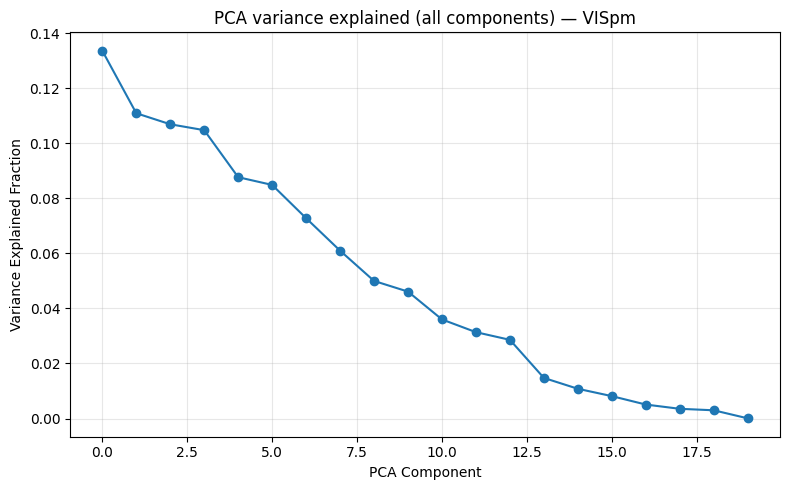

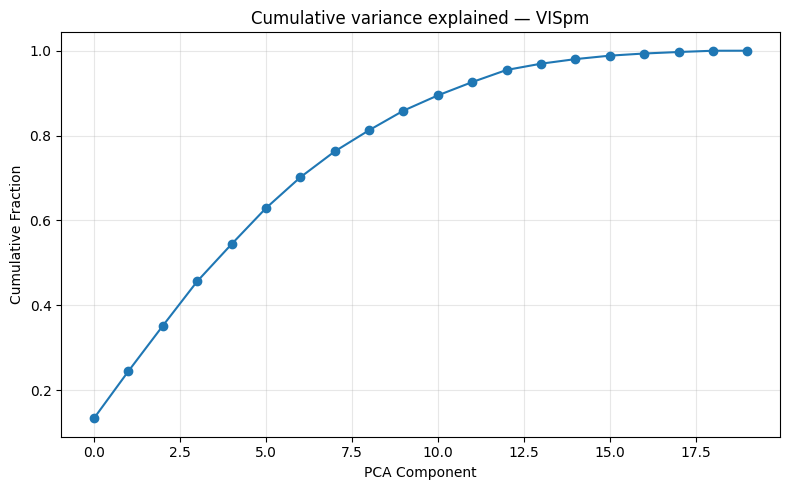

In [10]:
# ------------------------------------------------
# PCA on NMF factors (power-normalized)
# ------------------------------------------------
print("Running PCA on NMF factors for", area)

W0 = W - W.mean(axis=0, keepdims=True)

U, S, Vt = np.linalg.svd(W0, full_matrices=False)

eigenvalues = (S**2) / (W.shape[0] - 1)
var_exp = eigenvalues / eigenvalues.sum()
cumvar = np.cumsum(var_exp)

# Save results
pca_results = {
    "eigenvalues": eigenvalues,
    "var_exp": var_exp,
    "cumvar": cumvar
}

# ------------------------------------------------
# PLOT ALL PCA FACTORS (variance explained)
# ------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(var_exp, marker='o')
plt.title(f"PCA variance explained (all components) — {area}")
plt.xlabel("PCA Component")
plt.ylabel("Variance Explained Fraction")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ------------------------------------------------
# OPTIONAL: also plot cumulative variance
# ------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(cumvar, marker='o')
plt.title(f"Cumulative variance explained — {area}")
plt.xlabel("PCA Component")
plt.ylabel("Cumulative Fraction")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [11]:
plt.figure(figsize=(10, 6))
for area in AREAS:
    plt.plot(all_var_exp[area], marker='o', label=area)
plt.title("PCA variance explained — all brain areas")
plt.xlabel("PCA Component")
plt.ylabel("Variance Explained Fraction")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


NameError: name 'all_var_exp' is not defined

<Figure size 1000x600 with 0 Axes>

🔹 Loading neural response matrix...
Detected: 39209 neurons, time bins=1

🔹 Loading ViT embeddings...
📦 ViT PCs covering 90% variance: 44

🔸 AREA: VISp
VISp: 14382 neurons
NMF done.
Running PCA on NMF factors...


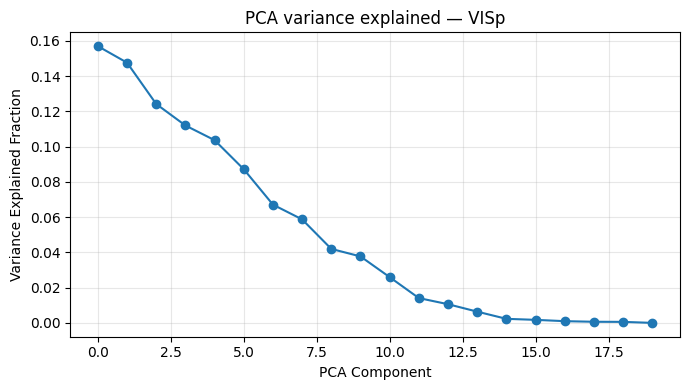

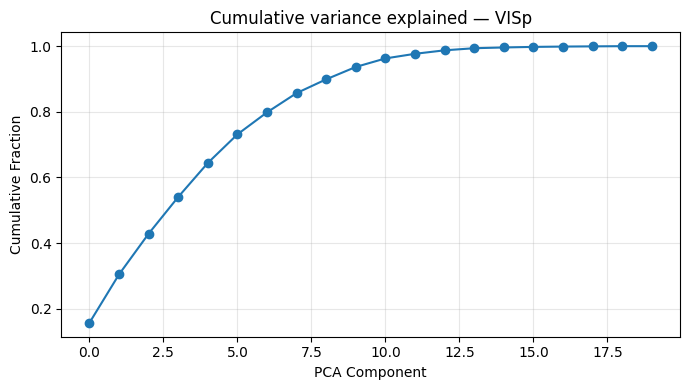


🔸 AREA: VISl
VISl: 8323 neurons
NMF done.
Running PCA on NMF factors...


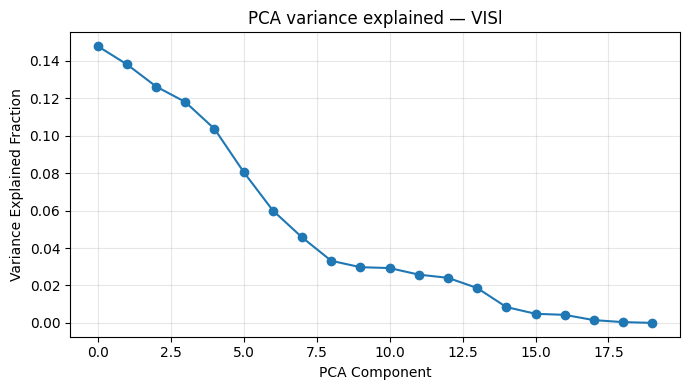

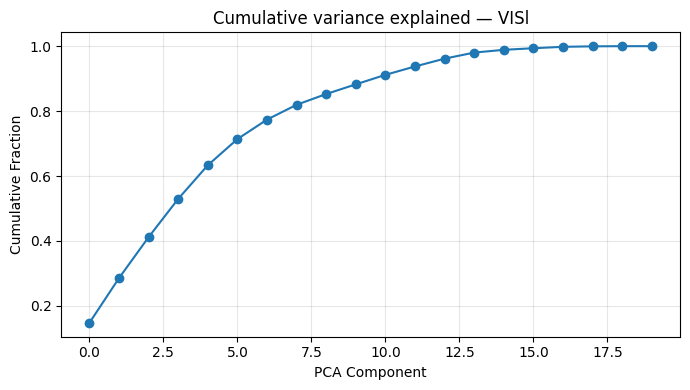


🔸 AREA: VISrl
VISrl: 5444 neurons
NMF done.
Running PCA on NMF factors...


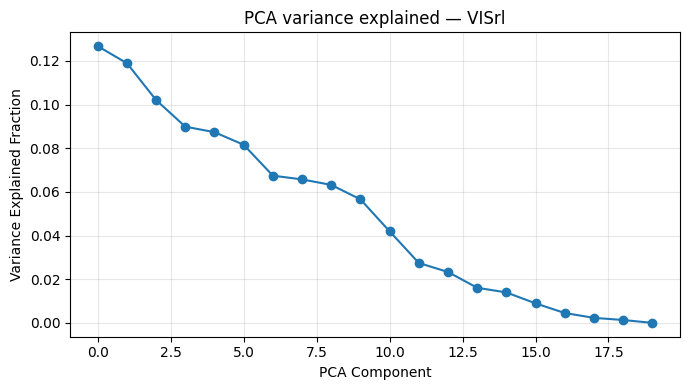

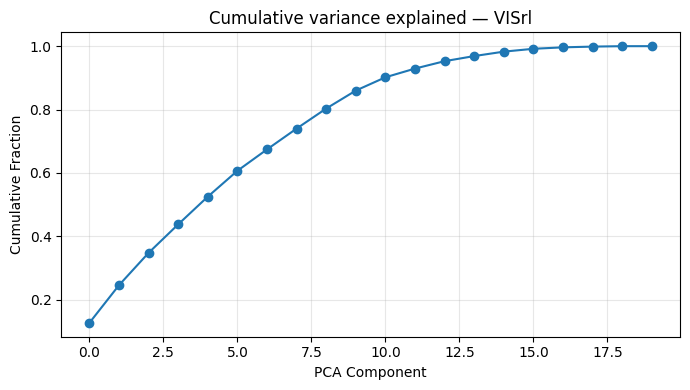


🔸 AREA: VISal
VISal: 4249 neurons
NMF done.
Running PCA on NMF factors...


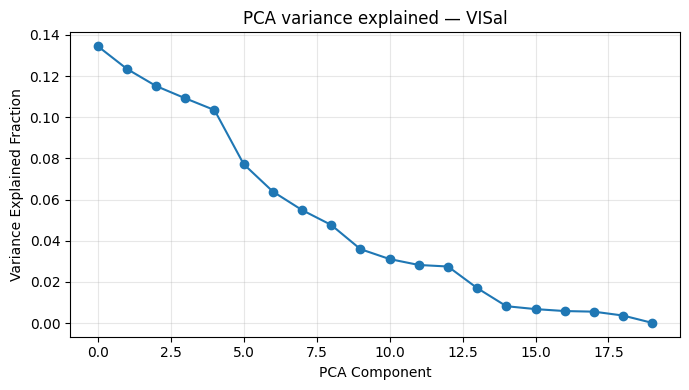

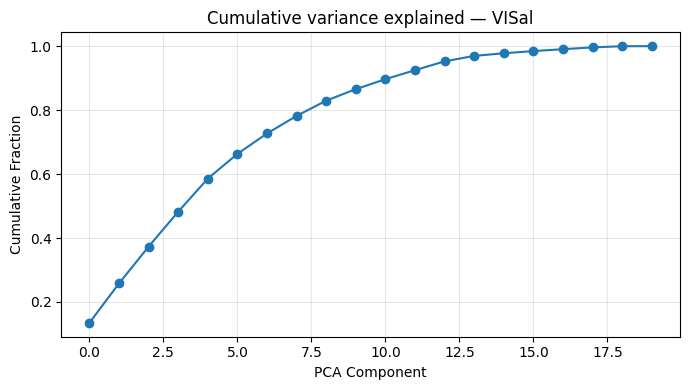


🔸 AREA: VISam
VISam: 2040 neurons
NMF done.
Running PCA on NMF factors...


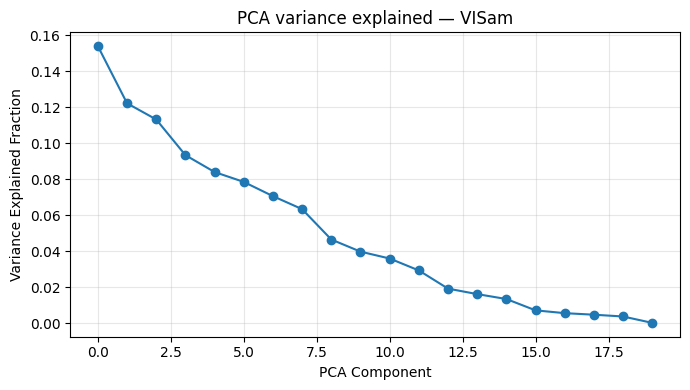

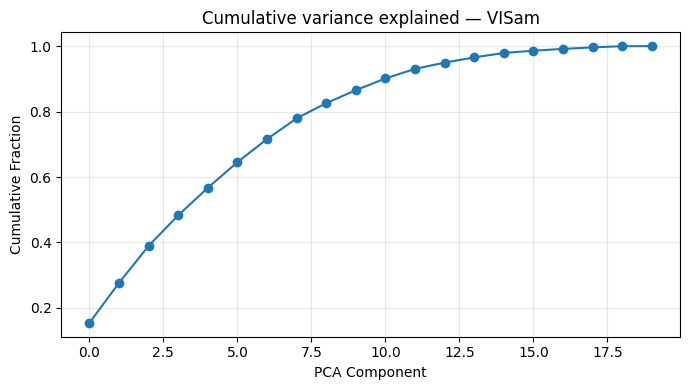


🔸 AREA: VISpm
VISpm: 4771 neurons
NMF done.
Running PCA on NMF factors...


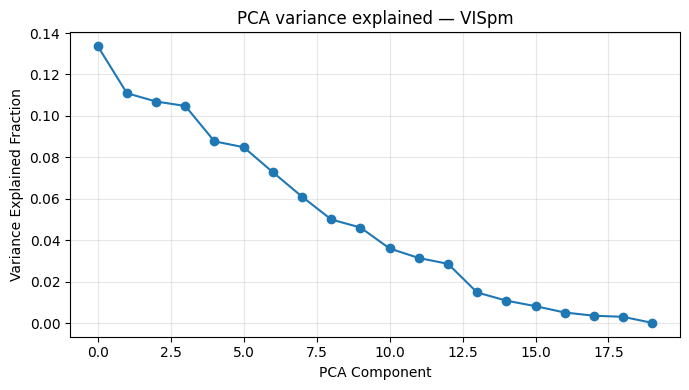

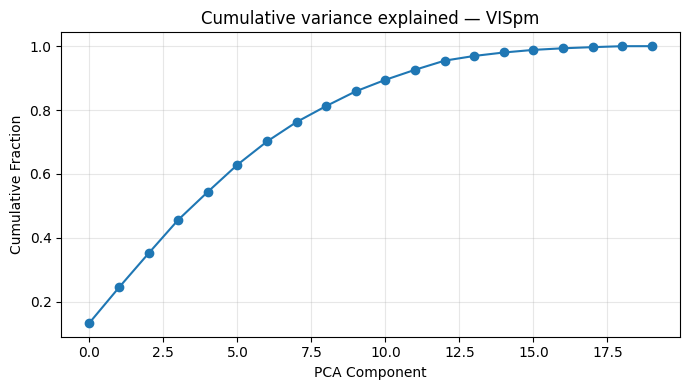


📊 Plotting combined figures for all brain areas...


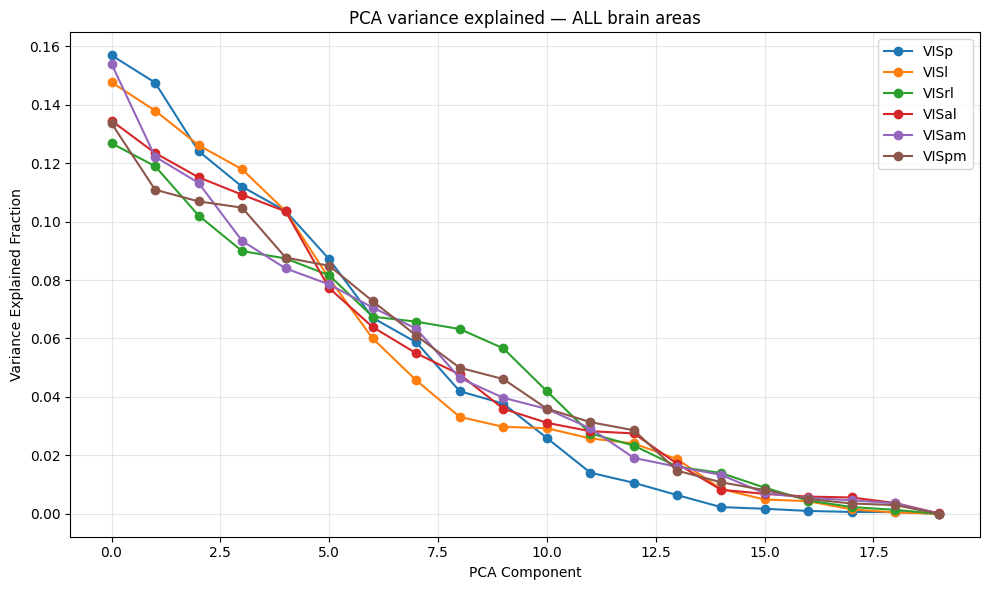

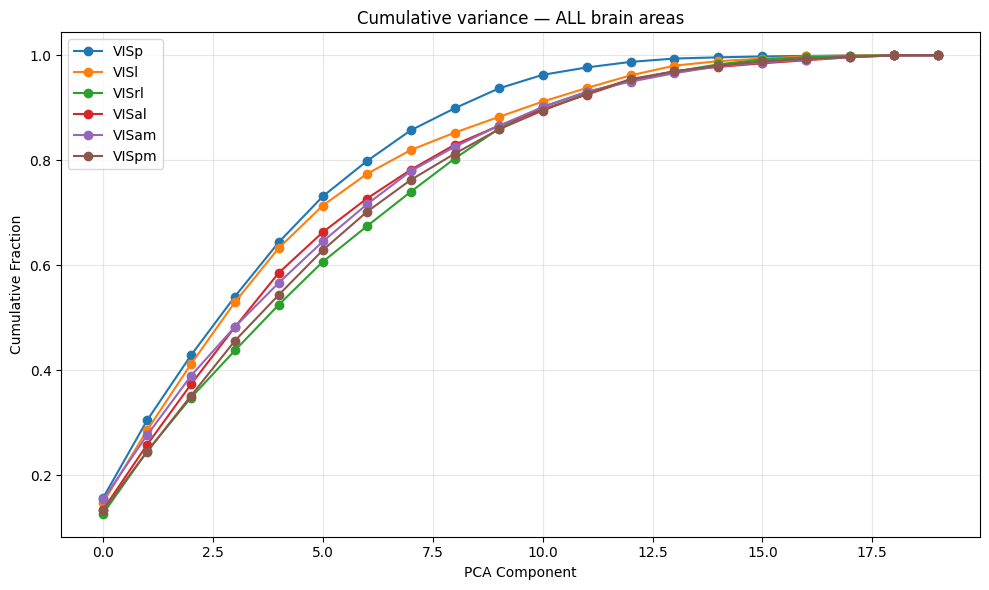


✨ Done! All brain areas processed.


In [12]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, NMF
from scipy.special import softmax
from skbio.stats.composition import clr

# ----------------------------------------------------
# CONFIG
# ----------------------------------------------------
NEURAL_PATH = '/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy'
AREAS_PATH  = '/home/maria/MITNeuralComputation/visualization/brain_area.npy'
VIT_PATH    = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'

AREAS = ["VISp", "VISl", "VISrl", "VISal", "VISam", "VISpm"]

N_IMAGES    = 118
N_TRIALS    = 50
N_COMPONENTS = 20
VAR_CUTOFF   = 0.90
RANDOM_SEED  = 42

# ----------------------------------------------------
# LOAD NEURAL DATA
# ----------------------------------------------------
print("🔹 Loading neural response matrix...")
dat_all = np.load(NEURAL_PATH, mmap_mode='r')
areas = np.load(AREAS_PATH, allow_pickle=True)

n_neurons_total, n_total = dat_all.shape
n_time = n_total // (N_IMAGES * N_TRIALS)

print(f"Detected: {n_neurons_total} neurons, time bins={n_time}")

# ----------------------------------------------------
# LOAD & PCA THE ViT EMBEDDINGS
# ----------------------------------------------------
print("\n🔹 Loading ViT embeddings...")
with open(VIT_PATH, 'rb') as f:
    vit_logits = pickle.load(f)['natural_scenes']

Xv = np.asarray(vit_logits)
Xv = softmax(Xv, axis=1)
Xv = clr(Xv + 1e-12)

vit_pca_full = PCA(random_state=RANDOM_SEED).fit(Xv)
vit_ncomp = np.searchsorted(
    np.cumsum(vit_pca_full.explained_variance_ratio_),
    VAR_CUTOFF
) + 1

vit_pca = PCA(n_components=vit_ncomp, random_state=RANDOM_SEED)
Zv = vit_pca.fit_transform(Xv)

print(f"📦 ViT PCs covering {VAR_CUTOFF*100:.0f}% variance: {vit_ncomp}")

# ----------------------------------------------------
# STORAGE FOR ALL AREA RESULTS
# ----------------------------------------------------
all_var_exp = {}
all_cumvar = {}

# ----------------------------------------------------
# MAIN LOOP — NMF + PCA FOR EACH AREA
# ----------------------------------------------------
for area in AREAS:
    print("\n========================================")
    print(f"🔸 AREA: {area}")
    print("========================================")

    # Select neurons
    mask = (areas == area)
    dat = dat_all[mask]
    n_neurons_area = dat.shape[0]
    print(f"{area}: {n_neurons_area} neurons")

    # Reshape neurons × images × trials × time
    dat = dat.reshape(n_neurons_area, N_IMAGES, N_TRIALS, n_time)

    # Stimulus-locked average: neurons × images
    dat_avg = dat.mean(axis=(2, 3))

    # NMF input: images × neurons (non-negative)
    X = np.maximum(dat_avg.T, 0)

    # ------------------------------------------------
    # NMF
    # ------------------------------------------------
    nmf = NMF(
        n_components=N_COMPONENTS,
        init='nndsvda',
        max_iter=5000,
        random_state=RANDOM_SEED
    )
    W = nmf.fit_transform(X)  # images × components
    H = nmf.components_

    print("NMF done.")

    # ------------------------------------------------
    # PCA on NMF factors → “power spectrum”
    # ------------------------------------------------
    print("Running PCA on NMF factors...")

    W0 = W - W.mean(axis=0, keepdims=True)
    U, S, Vt = np.linalg.svd(W0, full_matrices=False)

    eigenvalues = (S**2) / (W.shape[0] - 1)
    var_exp = eigenvalues / eigenvalues.sum()
    cumvar = np.cumsum(var_exp)

    # store for combined plot
    all_var_exp[area] = var_exp
    all_cumvar[area] = cumvar

    # ------------------------------------------------
    # INDIVIDUAL AREA PLOTS
    # ------------------------------------------------
    plt.figure(figsize=(7,4))
    plt.plot(var_exp, marker='o')
    plt.title(f"PCA variance explained — {area}")
    plt.xlabel("PCA Component")
    plt.ylabel("Variance Explained Fraction")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(cumvar, marker='o')
    plt.title(f"Cumulative variance explained — {area}")
    plt.xlabel("PCA Component")
    plt.ylabel("Cumulative Fraction")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# ----------------------------------------------------
# COMBINED PLOTS FOR ALL AREAS
# ----------------------------------------------------
print("\n📊 Plotting combined figures for all brain areas...")

# ---------- Variance spectrum -----------
plt.figure(figsize=(10,6))
for area in AREAS:
    plt.plot(all_var_exp[area], marker='o', label=area)
plt.title("PCA variance explained — ALL brain areas")
plt.xlabel("PCA Component")
plt.ylabel("Variance Explained Fraction")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ---------- Cumulative variance ----------
plt.figure(figsize=(10,6))
for area in AREAS:
    plt.plot(all_cumvar[area], marker='o', label=area)
plt.title("Cumulative variance — ALL brain areas")
plt.xlabel("PCA Component")
plt.ylabel("Cumulative Fraction")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✨ Done! All brain areas processed.")
